In [1]:
from pathlib import Path

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from layouts import Layout
from layouts.library import surface_code
from layouts.util.transmons import set_freq_groups, set_target_freqs, sample_freqs, any_collisions, get_num_collisions

# Distance-3 surface code

In [2]:
DISTANCE = 3

GROUP_FREQS = np.array([5.00, 5.07, 5.14, 5.21, 5.28]) # Following IBM definitions
GROUP_ANHARMS = np.repeat(-0.33, len(GROUP_FREQS))

layout = surface_code(DISTANCE, mixed_layout=False)
set_freq_groups(layout)
set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

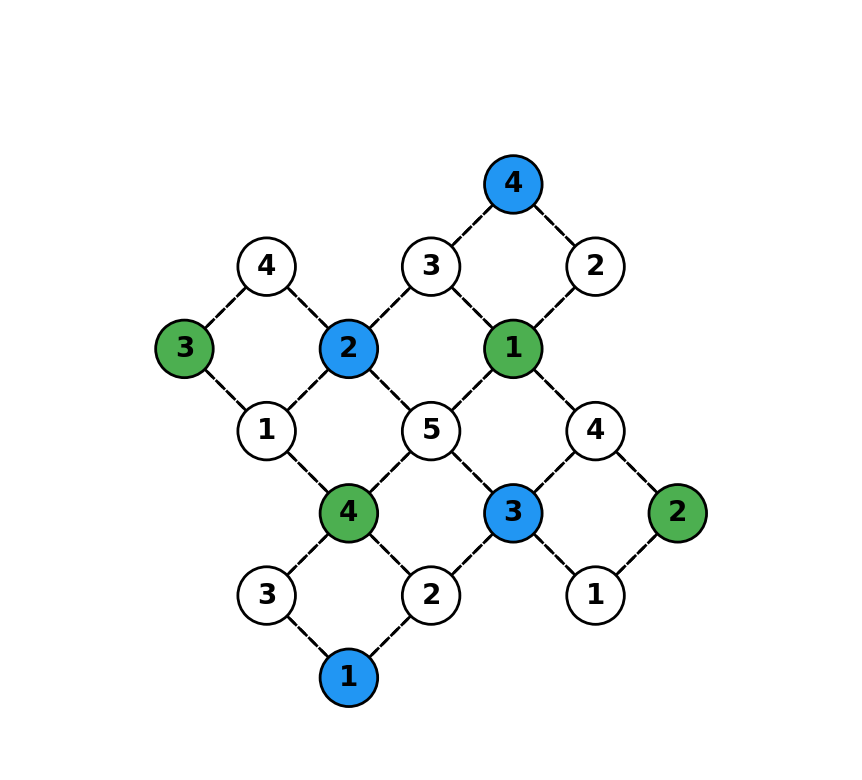

In [3]:
fig, ax = plt.subplots(dpi=200)

layout.plot(param_label="freq_group", axis=ax)
plt.tight_layout()
plt.show()

# Scan for distance 3

In [47]:
MIN_FREQ_VAR = 0.004
MAX_FREQ_VAR = 0.060
NUM_FREQ_VARS = 22
NUM_SEEDS = 10000

FREQ_VARS = np.geomspace(MIN_FREQ_VAR, MAX_FREQ_VAR, NUM_FREQ_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

BOUNDS = [0.017, 0.030, 0.004, 0.017, 0.025, 0.017]

collisions = np.zeros((NUM_FREQ_VARS, NUM_SEEDS), dtype=int)

for var_ind, freq_var in enumerate(FREQ_VARS):
    for seed_ind, seed in enumerate(SEEDS):
        sample_freqs(layout, seed, freq_var)
        if not any_collisions(layout, BOUNDS):
            collisions[var_ind, seed_ind] = 1

In [48]:
device_yield = np.mean(collisions, axis= 1)

With the spectator collision enabled

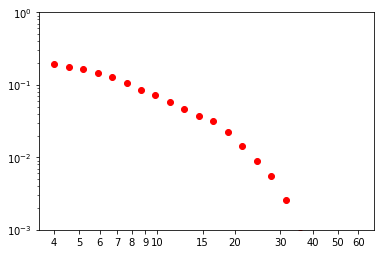

In [60]:
fig, ax = plt.subplots()

#qubit_target_freq_vars = [layout.param("target_freq", q) * FREQ_VARS * 1e3 for q in layout.get_qubits()]
#mean_freq_vars = np.mean(qubit_target_freq_vars, axis=0)

#ax.scatter(mean_freq_vars, device_yield, color="red")
ax.scatter(FREQ_VARS*1e3, device_yield, color="red")
ax.set_xscale("log")

ax.set_yscale("log")

#ax.set_xticks([10, 20, 30, 40, 50, 60, 70, 80, 80, 90, 100])
ax.set_xticks([4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60])
#ax.set_xticklabels(["10", "20", "30", "40", "50", "60", "70", "80", "80", "90", "100"])
ax.set_xticklabels(["4", "5", "6", "7", "8", "9", "10", "15", "20", "30", "40", "50", "60"])


ax.set_ylim(1e-3, 1)
plt.show()

# Scan with distance as well

In [57]:
MIN_FREQ_VAR = 0.004
MAX_FREQ_VAR = 0.060
NUM_FREQ_VARS = 22
NUM_SEEDS = 20000

DISTANCES = [3, 5, 7]
FREQ_VARS = np.geomspace(MIN_FREQ_VAR, MAX_FREQ_VAR, NUM_FREQ_VARS)
SEEDS = np.arange(1, NUM_SEEDS + 1)

BOUNDS = [0.017, 0.030, 0.004, 0.017, 0.025, 0.017]

collisions = np.zeros((len(DISTANCES), NUM_FREQ_VARS, NUM_SEEDS), dtype=int)

for dist_ind, distance in enumerate(DISTANCES):
    layout = surface_code(distance, mixed_layout=False)
    
    set_freq_groups(layout)
    set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

    for var_ind, freq_var in enumerate(FREQ_VARS):
        for seed_ind, seed in enumerate(SEEDS):
            sample_freqs(layout, seed, freq_var, relative_var=False)
            if not any_collisions(layout, BOUNDS):
                collisions[dist_ind, var_ind, seed_ind] = 1

In [64]:
collision_arr = xr.DataArray(
    collisions,
    dims = ["distance", "freq_var", "seed"],
    coords = dict(
        distance = DISTANCES,
        freq_var = FREQ_VARS,
        seed = SEEDS
    )
)

In [65]:
LOAD_DATA=False

if LOAD_DATA:
    DISTANCES = [3, 5, 7]
    MAX_FREQ_VAR = 1e-2
    NUM_SEEDS = 50000
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)

    data_arr_name = f"tmon_tmob_yield_scan_dist_{*DISTANCES,}_max_var_{MAX_FREQ_VAR}_seeds_{NUM_SEEDS}.nc"
    collisions = xr.load_dataarray(data_folder/data_arr_name)

In [66]:
#total_collisions = collisions.sum(dim="collision_type")
#collision_stats = collisions.sum(dim="seed")

#zero_collision_runs = xr.where(total_collisions == 0, 1, 0)
device_yield = collision_arr.mean(dim="seed")

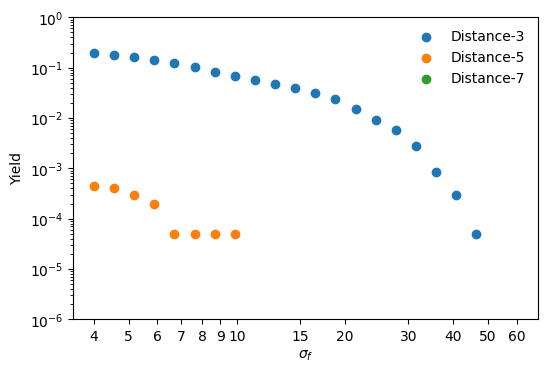

In [69]:
fig, ax = plt.subplots(dpi=100)

for dist in device_yield.distance.values:
    label = f"Distance-{dist}"
    ax.scatter(
        device_yield.freq_var * 1e3, 
        device_yield.sel(distance=dist),
        label=label,
    )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{f}$")
ax.set_ylabel(r"Yield")
ax.set_yscale("log")
ax.set_ylim(1e-6, 1)
ax.set_xticks([4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 60])
#ax.set_xticklabels(["10", "20", "30", "40", "50", "60", "70", "80", "80", "90", "100"])
ax.set_xticklabels(["4", "5", "6", "7", "8", "9", "10", "15", "20", "30", "40", "50", "60"])
ax.legend(frameon=False)

plt.show()

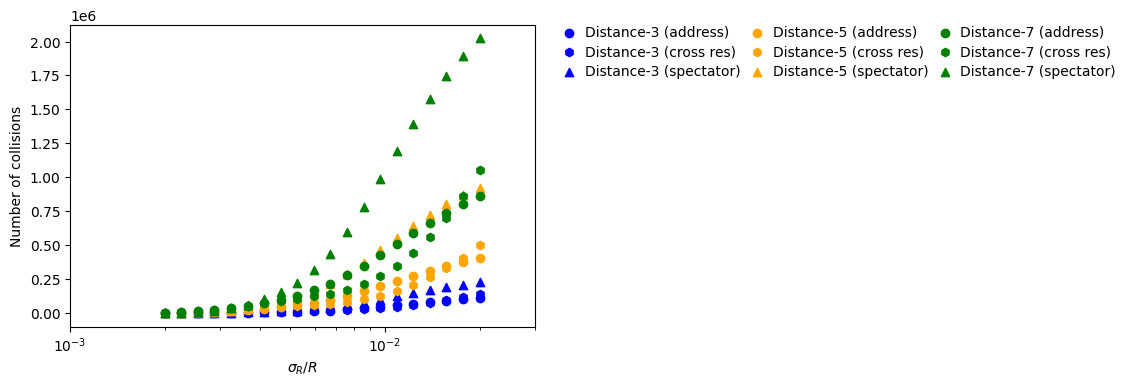

In [17]:
fig, ax = plt.subplots(dpi=100)

markers = dict(
    address = "o",
    cross_res = "h",
    spectator = "^"
)

colors = dict(dist_3 = "blue", dist_5 = "orange", dist_7 = "green")

for dist in collision_stats.distance.values:
    color = colors[f"dist_{dist}"]
    for col_type in collision_stats.collision_type.values:
        
        col_label = "cross res" if col_type == "cross_res" else col_type
        label = f"Distance-{dist} ({col_label})"
        ax.scatter(
            collision_stats.freq_var * 2, 
            collision_stats.sel(distance=dist, collision_type=col_type),
            label=label,
            color=color,
            marker = markers[col_type]
        )
    
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma_{R}/R$")
ax.set_ylabel(r"Number of collisions")
ax.set_xlim(1e-3, 3e-2)
ax.legend(
    frameon=False, 
    ncol=3,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    handletextpad=0.4,
    labelspacing=0.4,
    borderpad=0,
    markerscale=1.0,
    handlelength=1.5,
    borderaxespad=0.05,
    columnspacing=0.4
)

plt.show()

In [177]:
SAVE_DATA = True

if SAVE_DATA:
    notebook_dir = Path.cwd()
    data_folder = notebook_dir / "data"
    data_folder.mkdir(parents=True, exist_ok=True)
    
    data_arr_name = f"tmon_tmob_yield_scan_dist_{*DISTANCES,}_max_var_{MAX_FREQ_VAR}_seeds_{NUM_SEEDS}.nc"
    collisions.to_netcdf(data_folder/data_arr_name)

# Misc

In [96]:

import math

delta_f = 27.99
sigma_f = 4

a =  delta_f / 
integral = np.sqrt(np.pi/2)*(math.erf(a/np.sqrt(2)) + 1)
num_qubits = 17

print(integral**num_qubits)

289.5096488665332


In [124]:
NUM_SEEDS = 20000
BOUNDS = [0.017, 0.030, 0.004, 0.017, 0.025, 0.006]
SEEDS = np.arange(1, NUM_SEEDS + 1)

layout = surface_code(5, mixed_layout=False)
set_freq_groups(layout)
set_target_freqs(layout, GROUP_FREQS, GROUP_ANHARMS)

res = np.zeros(NUM_SEEDS, dtype=int)
for seed_ind, seed in enumerate(SEEDS):
    sample_freqs(layout, seed, 0.01, relative_var=False)
    if not any_collisions(layout, BOUNDS):
        res[seed_ind] = 1